# Train셋과 Test셋의 분포는 유사한가?

- 해당 문서는 아래 미디엄글을 기반으로 작성되었음을 알립니다.
    + 출처 : https://towardsdatascience.com/how-dis-similar-are-my-train-and-test-data-56af3923de9b

## 서론

- 캐글 컴피티션 및 회사 프로젝트에서 머신러닝을 활용한 모델을 만들 때 자주 겪는 문제중 하나는 Test셋의 모델 성능 이슈이다.
- Train셋에는 (당연히) 성능이 좋게나오지만 이상하게 Test셋에서는 성능이 낮게 나오는 경우가 있다.
- 우리는(사실 필자도 마찬가지..) 보통 오버피팅(overfitting)이라 생각하고 regularization 기법(L1 or L2 normalization 혹은 Tree계열 모델에서 terminal node의 샘플 수 조정 등)을 적용하지만 그렇지 않은 경우도 존재한다.
- 바로 Train셋과 Test셋 분포가 다를 때 발생한다.
- 여기에서는 오버피팅(overfitting)문제에 대해서는 따로 다루지 않는다. 그러니 오버피팅이 뭔지 알고싶다면 구글에 검색해서 한번 살펴보기 바란다.

## Train셋과 Test셋 분포의 차이

- 2개의 데이터셋의 분포가 다르다는 의미는 설명변수의 분포에 대한 이야기이다.
- 하나의 예로, 임의의 서비스를 이용하는 사용자의 나이이다.
    + 즉, Train셋에서는 10 ~ 30대의 사용자 데이터가 대부분이고 이를 기반으로 모델을 생성했다.
    + 그런데 성능평가를 수행할 Test셋에서는 40 ~ 60대의 사용자 데이터가 대부분이다.
    + 만일 학습된 모델이 사용자의 나이를 중요한 설명변수로 보고있다면 Test셋에 대한 모델 성능은 낮아질 수 밖에 없을 것이다.
    + 왜냐하면 학습에 사용된 Train셋은 40 ~ 60대의 사용자 나이가 거의 없기 때문에 학습이 제대로 안됐을 가능성이 크다.

- 이렇게 각각의 데이터셋의 설명변수간의 분포차이가 있는 것을 Covariate Shift라고 부른다.
- 아래 그림은 Covariate Shift가 있을 때 학습된 모델의 상황이다.
    + 파란색 점이 Train set의 설명변수, 검정색 점이 Test set의 설명변수 분포이다.
    + 빨간색 곡선은 정답이 되는 모델, 초록색 직선은 우리가 학습시킨 모델의 모습이다.

![](https://miro.medium.com/max/1232/1*L8Ua86qfwVRJAnaH_KZdFQ.png)


- 그렇다면 Train셋과 Test셋 분포 차이를 살펴보기 위해서는 어떻게 접근을 해야할까?
- 필자의 경우 이전에는 시각화를 통해서 분포에 서로 차이가 있는지 살펴봤다.
- 이런 작업은 중요하지만 변수가 적게는 수십개, 많게는 100개 200개이상이 되는 상황에서 시각화에만 의지한다면, 전체적인 작업의 효율이 떨어질 수 밖에 없다.
- 실제로 캐글 컴피티션에서 그 많은 변수에 대해서 시각화만 주구장창하다가 지쳐서 포기한 경우가 있었다.

## 모델을 사용해보는건 어떨까?

- 그렇다. 우리에게는 모델이라는 도구가 있다.
- 모델을 무조건 사용하자는 입장은 아니다. 하지만 한번 생각해보자. 100개이상의 변수를 시각화하여 일일히 전부 살펴볼 것인가? 아니면 모델을 이용하여 쉽게 파악을 할 것인가?


- 기본적인 아이디어는 다음과 같다.
    + __Train셋과 Tes셋의 분포에 차이가 있다면, 이 둘의 차이를 가져오는 설명변수들이 존재할 것이고 이를 기반으로 Train셋과 Test셋을 구별할 수 있는 Binary Classifier를 만들 수 있을 것이다.__

## 구현해보기

- 기존 글에서는 캐글의 [porto-seguro-safe-driver-prediction](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data) 데이터를 사용했다.
- 여기서는 필자가 이전에 참여했었던 [IEEE-CIS Fraud Detection](https://www.kaggle.com/c/ieee-fraud-detection/data) 대회의 데이터를 사용해서 다시 구현했다.
    + 단, 일부 변수만 사용해서 간단하게 Feature Engineering을 수행 후 살펴보도록한다.

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold as SKF
from sklearn.metrics import roc_auc_score as AUC

from multiprocessing import cpu_count

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
train_transaction = pd.read_csv("data/train_transaction.csv")
test_transaction = pd.read_csv("data/test_transaction.csv")

In [3]:
print(train_transaction.shape)
train_transaction.head()

(590540, 394)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
print(test_transaction.shape)
test_transaction.head()

(506691, 393)


,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- 해당 데이터에는 V1 ~ V339 변수가 포함되어있다. 이 변수들중 V1 ~ V100까지만 추출하여 구현해보도록하겠다. (메모리 이슈)

In [5]:
v_cols = [f"V{i}" for i in range(1, 100)]
train_transaction = train_transaction[["TransactionID"] + v_cols]
test_transaction = test_transaction[["TransactionID"] + v_cols]

In [6]:
print((train_transaction[v_cols].min() < 0).sum() == 0)

True


- V1 ~ V100까지 변수들중 최소값이 음수인 경우는 없으므로 NA를 -1로 대체하겠다.

In [7]:
train_transaction[v_cols] = train_transaction[v_cols].fillna(-1)
test_transaction[v_cols] = test_transaction[v_cols].fillna(-1)

- `is_train` 변수추가 : 해당 변수는 Train set에 포함되는지 여부를 나타내는 변수이다. Train set에서는 전부 1, Test sest에서는 전부 0로 셋팅한다.

In [8]:
train_transaction["is_train"] = 1
test_transaction["is_train"] = 0

- 2개의 데이터셋을 합친다.

In [9]:
all_transaction = pd.concat([train_transaction, test_transaction], axis=0, ignore_index=True)

- 이제 모델을 만들어보도록하자.
    + 랜덤포레스트를 사용했으며, 클래스 불균형을 막고자 StratifiedKFold를 수행했다.
    + 여기서 StratifiedKFold 수행시 n_split을 20으로 줬는데 해당 값은 선택사항이므로 10으로 바꿔도 상관없다.

In [10]:
X, y = all_transaction[v_cols].values, all_transaction["is_train"].values

In [11]:
m = RandomForestClassifier(n_jobs=cpu_count()-2, max_depth=5, min_samples_leaf = 30)
predictions = np.zeros(y.shape)

In [12]:
var_imps = pd.DataFrame({"variables": v_cols,})
var_imps["importance"] = 0

In [13]:
n_splits=20
skf = SKF(n_splits=n_splits, shuffle=True, random_state=100)

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    m.fit(X_train, y_train)
    probs = m.predict_proba(X_test)[:, 1] #calculating the probability
    predictions[test_idx] = probs
    
    var_imps["importance"] += m.feature_importances_ / n_splits

/mnt/d/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


- 랜덤포레스트를 이용하여 Binary Classifer를 만들었다. 이제 AUC를 평가해보도록한다.

In [14]:
print('ROC-AUC for train and test distributions:', AUC(y, predictions))

ROC-AUC for train and test distributions: 0.7071781339662673


- 만일 Train set과 Test set간에 차이가 크지 않았다면, AUC는 0.5에 가깝게 나와야한다.
- 그러나 AUC는 0.70을 넘는데 이는 Train set과 Test set간에 차이가 날 가능성이 크다.
- 그렇다면 V1 ~ V100중 어떤 변수가 가장 중요한가?
    + 평균 변수중요도 기준 상위 10에 해당하는 변수를 추출했다.

In [15]:
var_imps = var_imps.sort_values(by="importance", ascending=False).reset_index(drop=True)

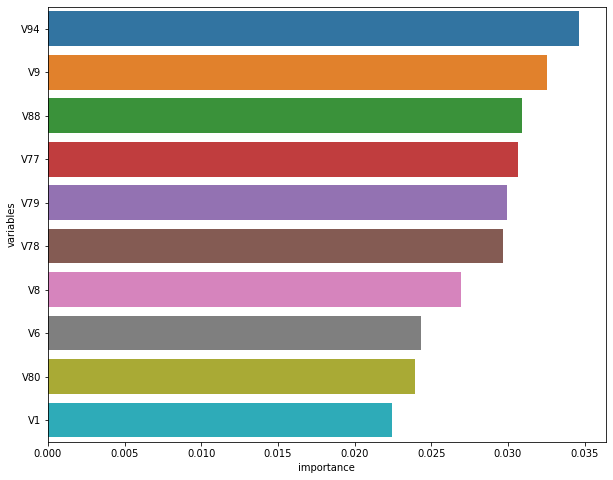

In [16]:
plt.figure(figsize=(10, 8))
sns.barplot(data=var_imps[:10], x="importance", y="variables", orient="h")

- 여기서 V77이 가장 높게 나왔으며, 이 변수를 scatter plot으로 시각화 하면 다음과 같다.

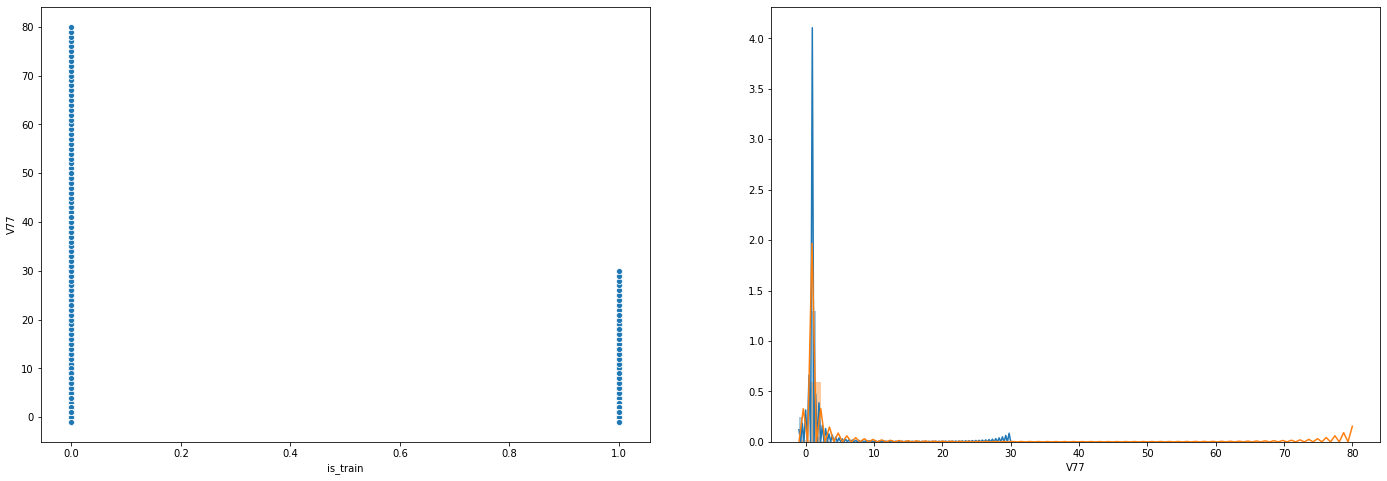

In [17]:
fig, axes = plt.subplots(ncols=2, nrows=1)
fig.set_size_inches(w=24, h=8)
sns.scatterplot(data=all_transaction, x="is_train", y="V77", ax=axes[0])

train_v77 = all_transaction.loc[all_transaction["is_train"] == 1, "V77"]
test_v77 = all_transaction.loc[all_transaction["is_train"] == 0, "V77"]
sns.distplot(train_v77, label="Train", ax=axes[1])
sns.distplot(test_v77, label="Test", ax=axes[1])

- Test셋의 V77의 경우 Train셋의 V77 최댓값보다 더 큰 값들이 존재하며, Train셋과 Test셋간의 V77분포 차이가 있다는 것을 확인 할 수 있다.
- 분포차이가 있는 것은 확인했으니 이 다음에는 무엇을 더 진행하면 좋을까?

## 변수제거

- 해당 방법은 Covariate Shift 문제가 관측됐을때 적용가능한 방법이다.
- 이 방법은 아래와 같이 진행한다.
    + 위에서 만든 모델의 변수중요도를 기준으로 가장 높은 변수를 하나 제거한다.
    + 기존 문제를 푸는 모델을 만든 후 성능을 떨어뜨리지 않는 변수들을 모은다.
    + 이러한 과정을 반복하면서 분포차이를 일으키는 변수들을 전부 제거한다.

## Weighted Sampling

- 해당 방법은 Covariate Shift 문제와 관계없이 적용가능한 방법이지만 여기서는 해당 문제에 촛점을 맞추어서 설명하겠다.
- Train 셋이라해도 Test 셋과 유사한 관측치가 있을 것이다.
- 이러한 경우 가중치를 후 Test 셋과 유사한 관측치를 샘플링하도록 적용할 수 있다.
- 가중치는 아래와 같이 계산이 가능하다.
    + $weight_i = \frac{P(test_i)}{P(train_i)} = \frac{P(test_i)}{1 - P(test_i)}$
    + i는 관측치의 index를 뜻한다.
    + 즉, i번째 관측치가 Train set 일 확률에 비해 Test set 일 확률로 Odds를 계산한 것이다.


- 구현하기 전에 Train 셋에서 가중치 분포를 확인해보도록한다.

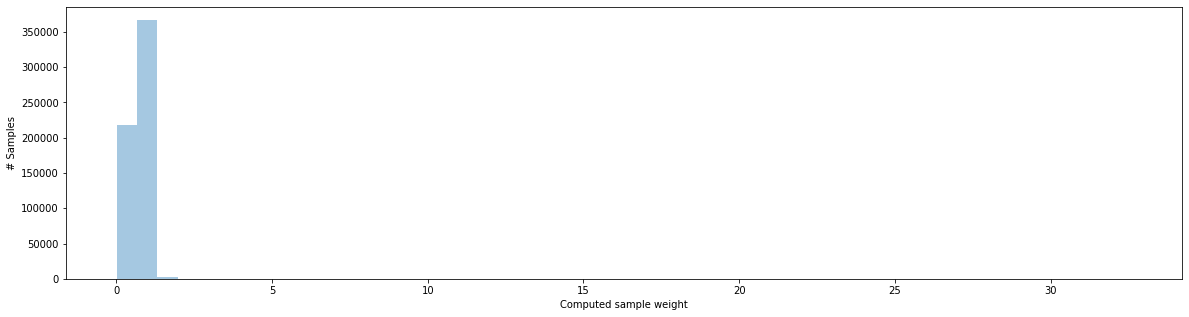

In [20]:
plt.figure(figsize=(20,5))
predictions_train = predictions[:590540] #filtering the actual training rows
weights = (1./predictions_train) - 1.

plt.xlabel('Computed sample weight')
plt.ylabel("# Samples")
sns.distplot(weights, kde=False)

In [22]:
(weights > 1).mean()

0.4781081721813933

- 1보다 큰 가중치들에 한해 가중치가 커질수록 Test 셋에 유사해진다.
- Train 셋의 47%가 Test 셋에 더 가깝다고 볼수 있다.
- 이를 이용해 기존 문제에 대한 모델을 만들 때 Weighted Sampling에서 가중치로 사용될 수 있다.
    + 그대로 사용하진 않고, 평균값으로 한번 나눠줌으로써 normalization을 수행 후 사용한다.

In [23]:
weights /= np.mean(weights)

## 정리

- 나름대로 이해한걸 바탕으로 해당 아이디어를 정리해보고 다른 데이터셋에 적용하여 직접 구현까지 시도했습니다.
- 머신러닝 모델을 이렇게도 사용할 수 있다는 걸 보여준 글이라는 점에 대해서 꽤 인상적인 자료였습니다.
- 특히 원래 풀고자하는 문제에 대해 모델을 만들었는데 Test 셋에 적용한 모델 성능이 그다지 좋지않고 오버피팅이 아니라면 이 방법을 통해 분포차이가 있는지 여부를 확인 후 만일 그렇다면 변수제거 및 Weighted Sampling을 통해 모델의 성능 개선을 이끌어 낼 수 있을 것 같습니다.
- 다만 이렇게 모델이 활용될 수 있다는 관점으로 접근해야지 이 글을 통해서 "모델을 이용한 방법론이 무조건 짱이네!" 라는 결론을 내리면 안됩니다.
- 어떤 아이디어가 떠오른다면 머신러닝 모델을 적용해도 되는지 우선 생각해보고나서 사용했으면 합니다.
- 혹시 잘못이야기한 부분이 있다면, byung2070@gmail.com 으로 피드백 보내주시면 수정 및 보완을 하겠습니다.